# Event Detection

We expect that as something happens, individuals will tweet about it in real-time causing bursts in Twitter activity. In 2011 Twitter [blogged](https://blog.twitter.com/2011/global-pulse) about how their site's activity was a reflection of global pulse, citing when volume spiked over 5,000 tweets per second following an earthquake.

Within our event timeline, we can identify specific times that importance for summarization in this way. We can call these subevents.

Using theory related to anomaly detection in signal processing for time series data, we can identify patterns that may significantly deviate from an underlying distribution in the dataset. By computing an expected frequency of occurrences per time window we can measure differences in behavior above or below this level for an interval, which may indicate an event activity. Furthermore, by calculating this expected frequency using a historical moving average, this approach can easily be applied to online data.

Related Twitter-Specific Frameworks
- [Twitter's Breakout Detection](https://blog.twitter.com/2014/breakout-detection-in-the-wild)
- [Twitter's Anomaly Detection](https://blog.twitter.com/2015/introducing-practical-and-robust-anomaly-detection-in-a-time-series)

**Measurment:** We define our measure as volume of tweets per minute, and an anomaly in this frequency would indicate a subevent.

**Method:** Anomalies are then detected by measuring the deviation from an expected frequency. Expected frequency is calculated using simple moving average using a window of 5 minutes, otherwise known as rolling mean. The intensity of the subevent is then measured as the deviation from the expected, and can be used to set a dynamic threshold for summarizing those which are most significant.

$expected = \frac{1}{n} \sum_{i=0}^{n-1} y-i$

Simple outlier detection algorithms look at values greated than a number of standard deviations from mean. Since we are limited to summarizing only that data which we can communicate we set a fixed threshold.

Subevents are considered for summarization if $y_{i} - expected > threshold$ where *threshold* is dynamically computed to include top *k* number of subevents.

### Input
- event tweets

### Output
- for every event minute
    - the volume of tweets
    - subevent rank, measured as deviation from moving average in descending order

#### import tools

In [308]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
import re

#### import data

In [309]:
event_name = input('Enter Event Name: ')
event_filename = re.sub("\W+", "", event_name.strip())

Enter Event Name: Xbox E3


In [310]:
df = pd.read_csv('data/final/event_%s_data.txt' % event_filename, sep='\t', encoding='utf-8', header=0, parse_dates=['created_at'], dtype={'twitter_id' : 'str'})
df.shape

(86475, 36)

## Tweet Volume at Minute Level

In [311]:
d = df.set_index('created_at').groupby([pd.TimeGrouper(freq='T')])['twitter_id'].agg(['count'])

In [312]:
d.shape

(999, 1)

In [313]:
print('Max tweets per minute: ', d.max().values)

Max tweets per minute:  [1246]


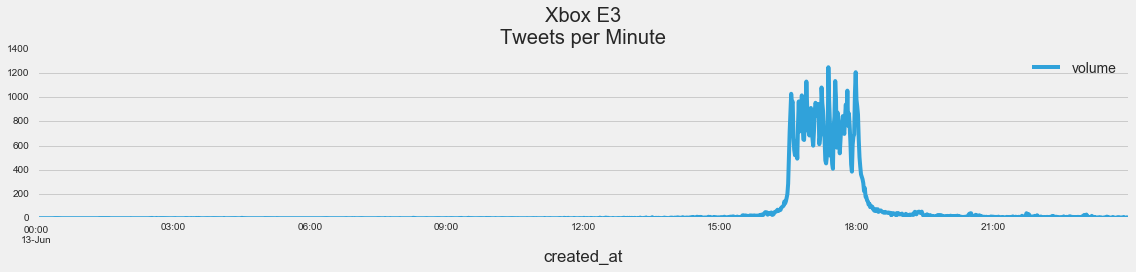

In [314]:
title = '%s\nTweets per Minute' % event_name

fig, ax = plt.subplots(figsize=(16,4))

d['count'].plot(kind='line', ax=ax, label='volume')

plt.title(title)
plt.legend(markerscale=2, fontsize=14)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/eventdetect_%s.png' % title.replace('\n', ' ').replace(' ', '_').replace(':', ''))

### Compute Moving Average, Deviation, Threshold
- bins = 1 minute
- window = 2 minute (historical only)
- k = 25

In [315]:
timeframe = pd.date_range(d.index.min(), d.index.max(), freq='T')
d = d.reindex(timeframe, fill_value=0)

In [316]:
window = 2

In [317]:
d['mean'] = d['count'].rolling(window=window).agg(['mean'])
d['std'] = d['count'].rolling(window=window).agg(['std'])

In [318]:
d['deviation'] = d['count'] - d['mean']

In [319]:
k = 25
threshold = d[d['deviation'] > 0]['deviation'].sort_values(ascending=False).iloc[:k].min()

### Visualize
- get timeline slice of top 50, plus 1 hour padding

In [320]:
viz_k = 50
threshold_viz = d[d['deviation'] > 0]['deviation'].sort_values(ascending=False).iloc[:viz_k].min()
viz_start = d[d['deviation'] > threshold_viz].index.min() - pd.DateOffset(hours=1)
viz_end = d[d['deviation'] > threshold_viz].index.max() + pd.DateOffset(hours=1)

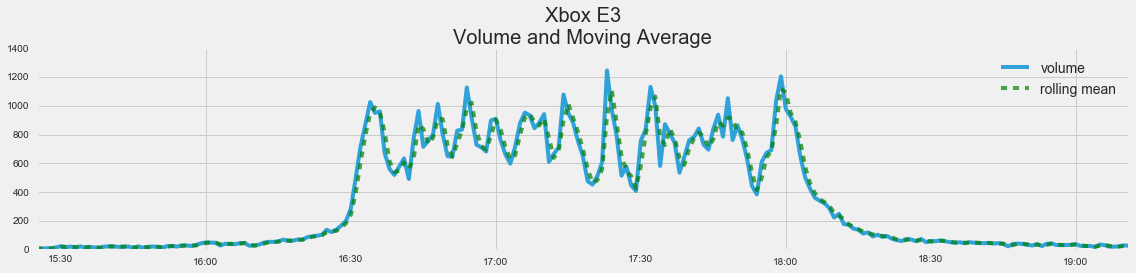

In [321]:
title = '%s\nVolume and Moving Average' % event_name
ax = d[viz_start:viz_end]['count'].plot(figsize=(16,4), label='volume')
d[viz_start:viz_end]['mean'].plot(ax=ax, style='g--', alpha=.70, label='rolling mean')
plt.title(title)
plt.legend(markerscale=2, fontsize=14)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/eventdetect_%s.png' % title.replace('\n', ' ').replace(' ', '_').replace(':', ''))

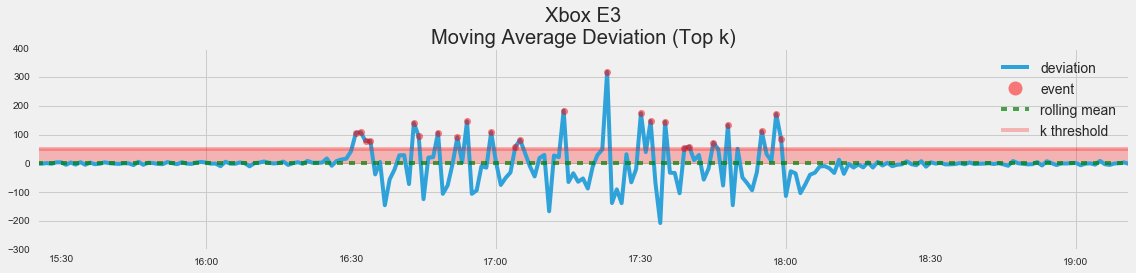

In [322]:
title = '%s\nMoving Average Deviation (Top k)' % event_name
ax = d[viz_start:viz_end]['deviation'].plot(figsize=(16,4), label='deviation')
#d[viz_start:viz_end]['std'].plot(ax=ax, color='r', alpha=.25, label='+1 std')
d[d['deviation'] > threshold][viz_start:viz_end]['deviation'].plot(ax=ax, style='ro', alpha=.50, label='event')
ax.axhline(y=0, linestyle='--', c='g', alpha=.70, label='rolling mean')
ax.axhline(y=threshold, linestyle='-', color='r', alpha=.25, label='k threshold')
#ax.fill_between(d.index, 0, 0 + d['std'], alpha=.25, color='r')
ax.fill_between(d.index, 0, threshold, alpha=.25, color='r')
plt.title(title)
plt.legend(markerscale=2, fontsize=14)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/eventdetect_%s.png' % title.replace('\n', ' ').replace(' ', '_').replace(':', ''))

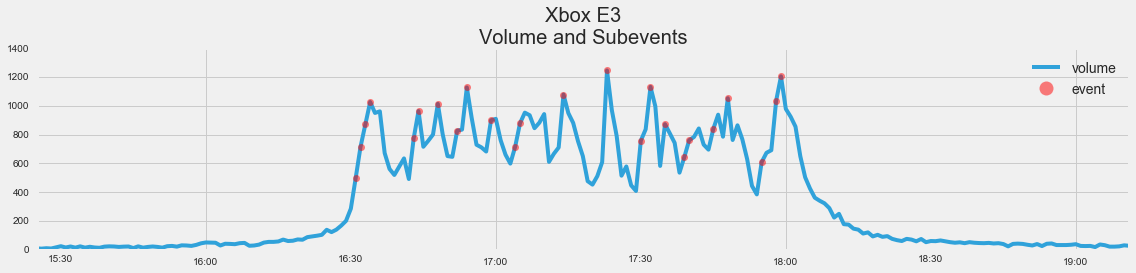

In [323]:
title = '%s\nVolume and Subevents' % event_name
ax = d[viz_start:viz_end]['count'].plot(figsize=(16,4), label='volume')
d[d['deviation'] > threshold][viz_start:viz_end]['count'].plot(ax=ax, style='ro', alpha=.50, label='event')
plt.title(title)
plt.legend(markerscale=2, fontsize=14)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/eventdetect_%s.png' % title.replace('\n', ' ').replace(' ', '_').replace(':', ''))

### Rank Subevents
- on deviation descending

In [324]:
d['rank_subevents'] = d['deviation'].rank(axis=0, method='first', ascending=False)

#### output

In [325]:
d.to_csv('data/final/event_%s_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=True)

## Subevents + Engagements Method
- using $tweets + tweets * \log(engagements)$

In [326]:
df['engagements'] = df['favorite_count'] + df['retweet_count']

In [327]:
dplus = df.set_index('created_at').groupby([pd.TimeGrouper(freq='T')])['engagements'].agg(['sum'])
dplus.columns = ['engagements']

In [328]:
timeframe = pd.date_range(dplus.index.min(), dplus.index.max(), freq='T')
dplus = dplus.reindex(timeframe, fill_value=0)

In [329]:
dplus = pd.concat([d['count'], dplus], axis=1)
dplus.shape

(1440, 2)

In [330]:
dplus['count+'] = dplus.apply(lambda x: x['count'] + x['count'] * math.log1p(x['engagements']), axis=1)

### Compute Moving Average, Deviation, Threshold
- bins = 1 minute
- window = 2 minute (historical only)
- k = 25

In [331]:
dplus['mean'] = dplus['count+'].rolling(window=window).agg(['mean'])
dplus['std'] = dplus['count+'].rolling(window=window).agg(['std'])

In [332]:
dplus['deviation'] = dplus['count+'] - dplus['mean']

In [333]:
k = 25
threshold = dplus[dplus['deviation'] > 0]['deviation'].sort_values(ascending=False).iloc[:k].min()

### Visualize

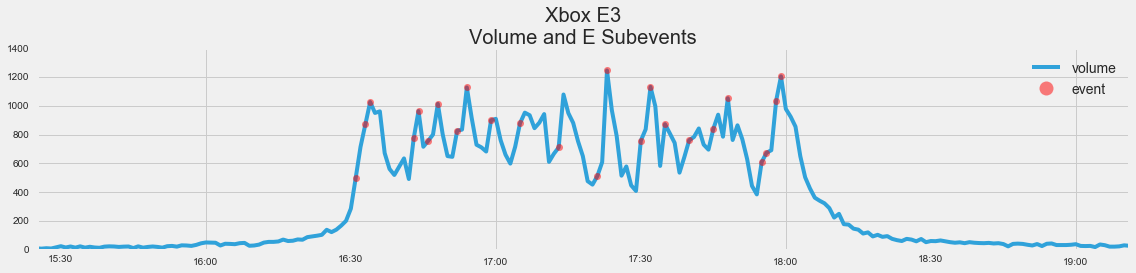

In [334]:
title = '%s\nVolume and E Subevents' % event_name
ax = dplus[viz_start:viz_end]['count'].plot(figsize=(16,4), label='volume')
dplus[dplus['deviation'] > threshold][viz_start:viz_end]['count'].plot(ax=ax, style='ro', alpha=.50, label='event')
plt.title(title)
plt.legend(markerscale=2, fontsize=14)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/eventdetect_%s.png' % title.replace('\n', ' ').replace(' ', '_').replace(':', ''))

### Rank E Subevents
- on deviation descending

In [335]:
dplus['rank_subevents'] = dplus['deviation'].rank(axis=0, method='first', ascending=False)

#### output

In [336]:
dplus.to_csv('data/final/event_%s_e_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=True)